 Apply transition -> Translated point: [ 2. -1.  0.  1.]
Rotated point: [ 2.22140538 -0.25565233  0.          1.        ]
Rigid body transformed point: [ 2.22140538 -0.25565233  0.          1.        ]
Transformed point by H1 followed by H2: [1.01247201 1.24634703 4.12132034 1.        ]

Corresponding image coordinates are: 
 [[310 493]
 [567 454]
 [635 220]
 [222 281]
 [486  63]
 [247  57]
 [347 233]]

The estimated projection matrix: 
 [[-7.34970124e-02 -3.97178383e-02  5.38566168e-02 -5.54625977e-01]
 [-1.79444057e-03  1.72426812e-02  8.02550868e-02 -8.22049809e-01]
 [-2.47866261e-05 -1.17511600e-04  1.07729714e-04 -1.68790310e-03]]
Bottom-right element of K is zero. Skipping normalization.
Intrinsic matrix: 
 [[1.23655163e-04 2.71189827e-05 0.00000000e+00]
 [3.79216120e-02 7.28241744e-02 0.00000000e+00]
 [9.93974481e-02 0.00000000e+00 0.00000000e+00]]
Rotation matrix: 
 [[-0.18492091  0.80152475 -0.56864957]
 [ 0.81989234  0.4448472   0.36039912]
 [ 0.          0.          0.      

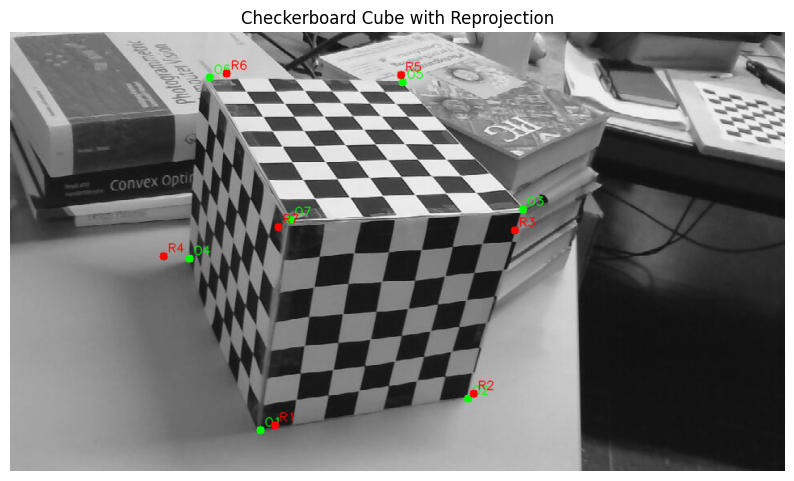

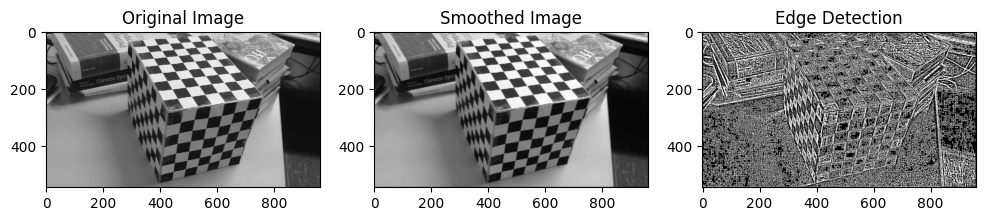

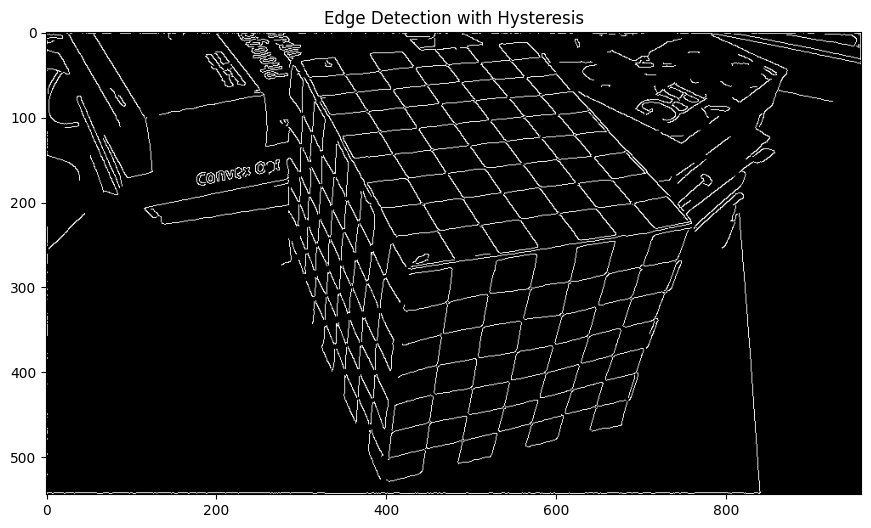

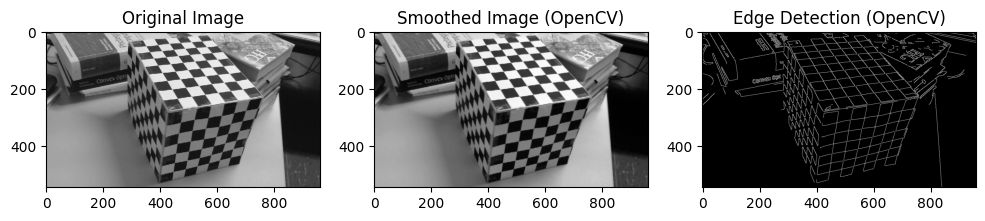

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Part 1
x = np.array([1, -1, 2, 1])  # points

t = np.array([1, 0, -2])
T = np.eye(4)
T[:3, 3] = t

x_translated = T @ x
print(" Apply transition -> Translated point:", x_translated)

phi = np.deg2rad(20)
Rz = np.array([
    [np.cos(phi), -np.sin(phi), 0, 0],
    [np.sin(phi), np.cos(phi), 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

x_rotated = Rz @ x_translated
print("Rotated point:", x_rotated)

rigid_transformation = Rz @ T  #(translation + rotation)
x_rigid = rigid_transformation @ x
print("Rigid body transformed point:", x_rigid)

H1 = np.array([
    [1, 0, 0, 0],
    [0, np.sqrt(2)/2, np.sqrt(2)/2, -1],
    [0, -np.sqrt(2)/2, np.sqrt(2)/2, 2],
    [0, 0, 0, 1]
])
x_H1 = H1 @ x

H2 = np.array([
    [np.sqrt(3)/2, -0.5, 0, 0],
    [0.5, np.sqrt(3)/2, 0, 1],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])
x_H2 = H2 @ x_H1
print("Transformed point by H1 followed by H2:", x_H2)

# Part 2: Intrinsic and Extrinsic Parameters, DLT
image = cv2.imread(r"C:\Users\DELL\Documents\checkerboard_cube[1]\checkerboard_cube\cube0.jpg", cv2.IMREAD_GRAYSCALE)
color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)


X = np.array([
    [0, 0, 0],
    [7, 0, 0],
    [7, 0, 7],
    [0, 0, 7],
    [7, 9, 7],
    [0, 9, 7],
    [0, 9, 0]
])
x = None

def get_points(event, x, y, flags, param):
    global points
    if event == cv2.EVENT_LBUTTONDOWN:
        points.append((x, y))
        if len(points) == 7:
            cv2.destroyAllWindows()

points = []

cv2.namedWindow('Image')
cv2.setMouseCallback('Image', get_points)

while len(points) < 7:
    cv2.imshow('Image', image)
    cv2.waitKey(1)

x = np.array(points)
print("\nCorresponding image coordinates are: \n", x)

def dlt(x, X):
    n = x.shape[0]
    A = []
    for i in range(n):
        X_i = np.append(X[i], 1)
        zeros = np.zeros(4)
        x_i = x[i]
        A.append(np.concatenate((zeros, -X_i, x_i[1] * X_i)))
        A.append(np.concatenate((X_i, zeros, -x_i[0] * X_i)))

    A = np.array(A)

    # Performing SVD
    U, S, Vt = np.linalg.svd(A)
    P = Vt[-1].reshape(3, 4)

    return P

P = dlt(x, X)
print("\nThe estimated projection matrix: \n", P)

def rq_decomposition(A):
    A = np.flipud(A.T)
    Q, R = np.linalg.qr(A)
    R = np.flipud(R.T)
    Q = np.flipud(Q.T)
    D = np.diag(np.sign(np.diag(R)))
    R = R @ D
    Q = D @ Q

    return R, Q

def decompose_P(P):
    K, R = rq_decomposition(P[:, :3])


    if K[2, 2] != 0:
        K /= K[2, 2]
    else:
        print("Bottom-right element of K is zero. Skipping normalization.")

    X0 = -np.linalg.inv(P[:, :3]).dot(P[:, 3])

    return K, R, X0

K, R, X0 = decompose_P(P)
print('Intrinsic matrix: \n', K)
print('Rotation matrix: \n', R)
print('Projection center: \n', X0)

def compute_reprojection_error(P, X, x):
    X_h = np.hstack((X, np.ones((X.shape[0], 1))))
    x_proj = P.dot(X_h.T).T
    x_proj = x_proj[:, :2] / x_proj[:, 2, np.newaxis]
    err_reproj = np.linalg.norm(x - x_proj, axis=1)

    return x_proj, err_reproj

x_proj, err_reproj = compute_reprojection_error(P, X, x)

print("\nReprojected image coordinates: \n", x_proj)
print("\nReprojection error: \n", err_reproj)

def draw_points(image, points, color, label):
    for i, point in enumerate(points):
        cv2.circle(image, (int(point[0]), int(point[1])), 5, color, -1)
        cv2.putText(image, f"{label}{i+1}", (int(point[0]) + 5, int(point[1]) - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)

draw_points(color_image, x, (0, 255, 0), 'O')

draw_points(color_image, x_proj, (0, 0, 255), 'R')


plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
plt.title('Checkerboard Cube with Reprojection')
plt.axis('off')
plt.show()

# Part 3: Filters and Convolutions

image = cv2.imread(r"C:\Users\DELL\Documents\checkerboard_cube[1]\checkerboard_cube\cube1.jpg", cv2.IMREAD_GRAYSCALE)

def convolve(image, kernel):
    image_h, image_w = image.shape
    kernel_h, kernel_w = kernel.shape
    pad_h, pad_w = kernel_h // 2, kernel_w // 2


    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
    output = np.zeros_like(image)
    for i in range(image_h):
        for j in range(image_w):
            output[i, j] = np.sum(padded_image[i:i + kernel_h, j:j + kernel_w] * kernel)

    return output

mean_kernel = np.ones((3, 3)) / 9
gaussian_kernel = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
]) / 16

edge_kernel = np.array([
    [-1, -1, -1],
    [-1, 8, -1],
    [-1, -1, -1]
])

smoothed_image = convolve(image, mean_kernel)

edges = convolve(smoothed_image, edge_kernel)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Smoothed Image')
plt.imshow(smoothed_image, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Edge Detection')
plt.imshow(edges, cmap='gray')


def edge_detection(image, t1=100, t2=200):
    edges = cv2.Canny(image, t1, t2)
    return edges

edges_with_hysteresis = edge_detection(smoothed_image, t1=100, t2=200)
plt.figure(figsize=(12, 6))
plt.title('Edge Detection with Hysteresis')
plt.imshow(edges_with_hysteresis, cmap='gray')
plt.show()

# Comparison with OpenCV Methods

smoothed_image_cv = cv2.GaussianBlur(image, (3, 3), 1)

edges_cv = cv2.Canny(smoothed_image_cv, 100, 200)


plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Smoothed Image (OpenCV)')
plt.imshow(smoothed_image_cv, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Edge Detection (OpenCV)')
plt.imshow(edges_cv, cmap='gray')
plt.show()


Translated point: [ 2. -1.  0.  1.]
Rotated point: [ 2.22140538 -0.25565233  0.          1.        ]
Rigid body transformed point: [ 2.22140538 -0.25565233  0.          1.        ]
Transformed point by H1 followed by H2: [1.01247201 1.24634703 4.12132034 1.        ]

Corresponding image coordinates: 
 [[310 489]
 [568 452]
 [636 223]
 [220 281]
 [483  61]
 [244  60]
 [349 233]]

The estimated projection matrix: 
 [[-7.06993474e-02 -3.89590341e-02  5.51550964e-02 -5.60726633e-01]
 [-3.64771754e-04  1.71033704e-02  7.93306524e-02 -8.18192179e-01]
 [-1.99066256e-05 -1.15541439e-04  1.08916849e-04 -1.69594070e-03]]
Intrinsic matrix: 
 [[1.21883135e-04 2.81464827e-05 0.00000000e+00]
 [3.82027389e-02 7.16000103e-02 0.00000000e+00]
 [9.77665010e-02 0.00000000e+00 0.00000000e+00]]
Rotation matrix: 
 [[-0.17477055  0.79834864 -0.57627659]
 [ 0.80696257  0.45149161  0.38074498]
 [ 0.          0.          0.        ]]
Projection center: 
 [ 3.43448231 -4.59817613 11.32083581]

Reprojected image c

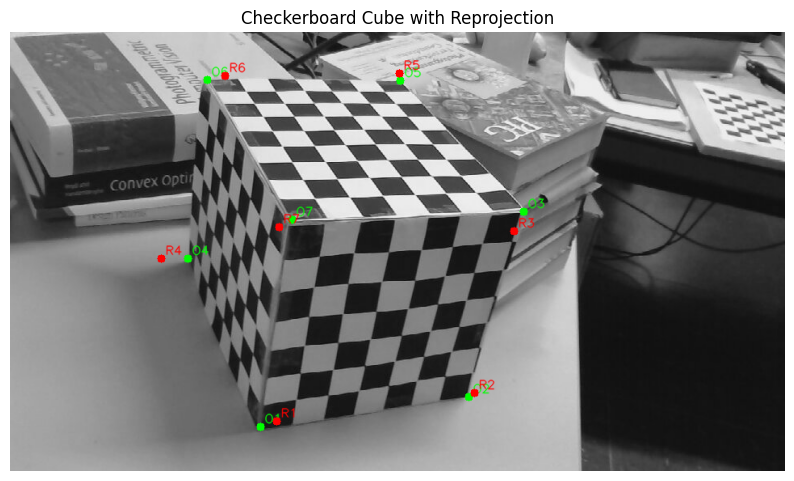

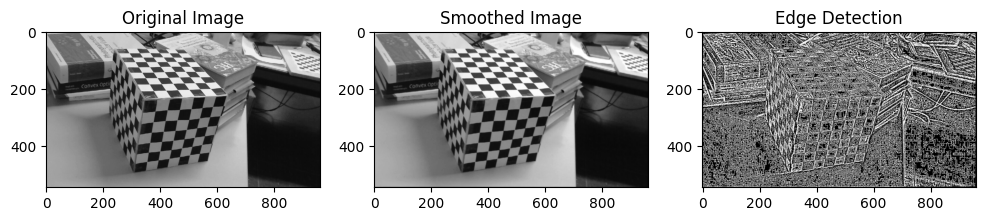

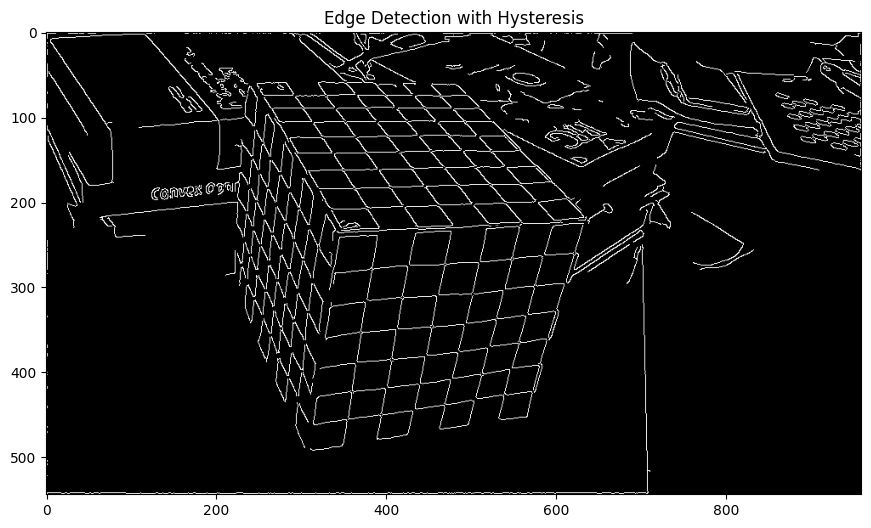

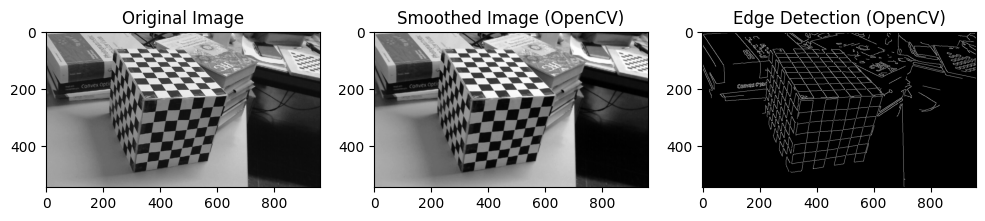

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
x = np.array([1, -1, 2, 1])
t = np.array([1, 0, -2])
T = np.eye(4)
T[:3, 3] = t
x_translated = T @ x
print("Translated point:", x_translated)
phi = np.deg2rad(20)
Rz = np.array([
    [np.cos(phi), -np.sin(phi), 0, 0],
    [np.sin(phi), np.cos(phi), 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])
x_rotated = Rz @ x_translated
print("Rotated point:", x_rotated)
rigid_transformation = Rz @ T
x_rigid = rigid_transformation @ x
print("Rigid body transformed point:", x_rigid)
H1 = np.array([
    [1, 0, 0, 0],
    [0, np.sqrt(2)/2, np.sqrt(2)/2, -1],
    [0, -np.sqrt(2)/2, np.sqrt(2)/2, 2],
    [0, 0, 0, 1]
])
H2 = np.array([
    [np.sqrt(3)/2, -0.5, 0, 0],
    [0.5, np.sqrt(3)/2, 0, 1],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])
x_H1 = H1 @ x
x_H2 = H2 @ x_H1
print("Transformed point by H1 followed by H2:", x_H2)
image = cv2.imread(r"C:\Users\DELL\Documents\checkerboard_cube[1]\checkerboard_cube\cube0.jpg", cv2.IMREAD_GRAYSCALE)
color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
X = np.array([
    [0, 0, 0],
    [7, 0, 0],
    [7, 0, 7],
    [0, 0, 7],
    [7, 9, 7],
    [0, 9, 7],
    [0, 9, 0]
])
x = None
def get_points(event, x, y, flags, param):
    global points
    if event == cv2.EVENT_LBUTTONDOWN:
        points.append((x, y))
        if len(points) == 7:
            cv2.destroyAllWindows()
points = []
cv2.namedWindow('Image')
cv2.setMouseCallback('Image', get_points)
while len(points) < 7:
    cv2.imshow('Image', image)
    cv2.waitKey(1)
x = np.array(points)
print("\nCorresponding image coordinates: \n", x)
def dlt(x, X):
    n = x.shape[0]
    A = []
    for i in range(n):
        X_i = np.append(X[i], 1)
        zeros = np.zeros(4)
        x_i = x[i]        
        A.append(np.concatenate((zeros, -X_i, x_i[1] * X_i)))
        A.append(np.concatenate((X_i, zeros, -x_i[0] * X_i)))    
    A = np.array(A)
    U, S, Vt = np.linalg.svd(A)
    P = Vt[-1].reshape(3, 4)    
    return P
P = dlt(x, X)
print("\nThe estimated projection matrix: \n", P)
def rq_decomposition(A):
    A = np.flipud(A.T)
    Q, R = np.linalg.qr(A)
    R = np.flipud(R.T)
    Q = np.flipud(Q.T)    
    D = np.diag(np.sign(np.diag(R)))
    R = R @ D
    Q = D @ Q    
    return R, Q
def decompose_P(P):
    K, R = rq_decomposition(P[:, :3])    
    if K[2, 2] != 0:
        K /= K[2, 2]
    else:
        print("Warning: Bottom-right element of K is zero. Skipping normalization.")
    X0 = -np.linalg.inv(P[:, :3]).dot(P[:, 3])    
    return K, R, X0
K, R, X0 = decompose_P(P)
print('Intrinsic matrix: \n', K)
print('Rotation matrix: \n', R)
print('Projection center: \n', X0)
def compute_reprojection_error(P, X, x):
    X_h = np.hstack((X, np.ones((X.shape[0], 1))))
    x_proj = P.dot(X_h.T).T
    x_proj = x_proj[:, :2] / x_proj[:, 2, np.newaxis]
    err_reproj = np.linalg.norm(x - x_proj, axis=1)    
    return x_proj, err_reproj
x_proj, err_reproj = compute_reprojection_error(P, X, x)
print("\nReprojected image coordinates: \n", x_proj)
print("\nReprojection error: \n", err_reproj)
def draw_points(image, points, color, label):
    for i, point in enumerate(points):
        cv2.circle(image, (int(point[0]), int(point[1])), 5, color, -1)
        cv2.putText(image, f"{label}{i+1}", (int(point[0]) + 5, int(point[1]) - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)
draw_points(color_image, x, (0, 255, 0), 'O')
draw_points(color_image, x_proj, (0, 0, 255), 'R')
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
plt.title('Checkerboard Cube with Reprojection')
plt.axis('off')
plt.show()
image = cv2.imread(r"C:\Users\DELL\Documents\checkerboard_cube[1]\checkerboard_cube\cube0.jpg", cv2.IMREAD_GRAYSCALE)

def convolve(image, kernel):
    image_h, image_w = image.shape
    kernel_h, kernel_w = kernel.shape
    pad_h, pad_w = kernel_h // 2, kernel_w // 2
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
    output = np.zeros_like(image)

    for i in range(image_h):
        for j in range(image_w):
            output[i, j] = np.sum(padded_image[i:i + kernel_h, j:j + kernel_w] * kernel)
    
    return output

mean_kernel = np.ones((3, 3)) / 9
gaussian_kernel = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
]) / 16

edge_kernel = np.array([
    [-1, -1, -1],
    [-1, 8, -1],
    [-1, -1, -1]
])

smoothed_image = convolve(image, mean_kernel)

edges = convolve(smoothed_image, edge_kernel)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Smoothed Image')
plt.imshow(smoothed_image, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Edge Detection')
plt.imshow(edges, cmap='gray')

def edge_detection(image, t1=100, t2=200):
    edges = cv2.Canny(image, t1, t2)
    return edges

edges_with_hysteresis = edge_detection(smoothed_image, t1=100, t2=200)
plt.figure(figsize=(12, 6))
plt.title('Edge Detection with Hysteresis')
plt.imshow(edges_with_hysteresis, cmap='gray')
plt.show()

# ============================================
# Comparison with OpenCV Methods
# ============================================
smoothed_image_cv = cv2.GaussianBlur(image, (3, 3), 1)

edges_cv = cv2.Canny(smoothed_image_cv, 100, 200)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Smoothed Image (OpenCV)')
plt.imshow(smoothed_image_cv, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Edge Detection (OpenCV)')
plt.imshow(edges_cv, cmap='gray')
plt.show()
